# Read data and randoms clsutering catalogs: 

**Aim:** Read data and randoms clustering catalogs from GLAM mocks with the expand option for the randoms. 

**Important:** This code can be run with MPI (srun -n X python ... ).

In [1]:
import logging
from mpytools import Catalog, setup_logging

import sys
sys.path.append('../')
from clustering_statistics.tools import read_clustering_catalog, get_catalog_fn, propose_fiducial

from mpi4py import MPI
mpicomm = MPI.COMM_WORLD

setup_logging(level=(logging.INFO if mpicomm.rank == 0 else logging.ERROR))

In [ ]:
# Note expand does not work for region: 'ALL' for now... 
# If you need ALL run the two regions (NGC and SGC) separately and concatenate them with Catalog.concatenate([cat_ngc, cat_sgc]).

attrs = {'version': 'glam-uchuu-v1-altmtl', 'tracer': 'LRG', 'region': 'NGC', 'imock': 101, 'nran': 4}

print('data are located: ', get_catalog_fn(kind='data', **attrs))
print('randoms are located: ', get_catalog_fn(kind='randoms', **attrs))

# need to compute WEIGHT_FKP for expanded catalogs .. (should be automatized in the future)
attrs['FKP_P0'] = propose_fiducial('catalog', tracer=attrs['tracer'])['FKP_P0']

data are located:  /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl101/loa-v1/mock101/LSScats/LRG_NGC_clustering.dat.h5
randoms are located:  [PosixPath('/dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl101/loa-v1/mock101/LSScats/LRG_NGC_0_clustering.ran.h5'), PosixPath('/dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl101/loa-v1/mock101/LSScats/LRG_NGC_1_clustering.ran.h5'), PosixPath('/dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl101/loa-v1/mock101/LSScats/LRG_NGC_2_clustering.ran.h5'), PosixPath('/dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl101/loa-v1/mock101/LSScats/LRG_NGC_3_clustering.ran.h5')]


In [3]:
# Can pass other functions to get catalog fn, default is: get_catalog_fn = get_catalog_fn
data = read_clustering_catalog(kind='data', weight='fkp', return_all_columns=True, mpicomm=mpicomm, **attrs) 
print(data)

[000000.05] [0/1] 02-10 17:09  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl101/loa-v1/mock101/LSScats/LRG_NGC_clustering.dat.h5.
[000000.18] [0/1] 02-10 17:09  tools                     INFO     Multiplying individual weights by WEIGHT_FKP


INFO:2026-02-10 17:09:34,946:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


[000000.69] [0/1] 02-10 17:09  jax._src.xla_bridge       INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
Catalog(csize=2941056, size=2941056, columns=['RA', 'DEC', 'Z', 'WEIGHT', 'WEIGHT_COMP', 'WEIGHT_FKP', 'WEIGHT_SYS', 'FRAC_TLOBS_TILES', 'NTILE', 'NX', 'TARGETID', 'INDWEIGHT', 'POSITION'])


In [4]:
expand = {'parent_randoms_fn': get_catalog_fn(kind='parent_randoms', version='data-dr2-v2', tracer=attrs['tracer'], nran=attrs['nran'])}
randoms = read_clustering_catalog(kind='randoms', weight='fkp', expand=expand, return_all_columns=True, mpicomm=mpicomm, **attrs) 
print(randoms)

[000002.81] [0/1] 02-10 17:09  tools                     INFO     Expanding randoms
[000002.81] [0/1] 02-10 17:09  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark_0_full_noveto.ran.h5.
[000002.92] [0/1] 02-10 17:09  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark_1_full_noveto.ran.h5.


/global/u2/e/edmondc/desi-clustering/nb/../clustering_statistics/tools.py:877: UserWarning: WEIGHT not in catalog
  warnings.warn('WEIGHT not in catalog')


[000003.03] [0/1] 02-10 17:09  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark_2_full_noveto.ran.h5.
[000003.13] [0/1] 02-10 17:09  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark_3_full_noveto.ran.h5.
[000003.24] [0/1] 02-10 17:09  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl101/loa-v1/mock101/LSScats/LRG_NGC_clustering.dat.h5.
[000003.24] [0/1] 02-10 17:09  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl101/loa-v1/mock101/LSScats/LRG_SGC_clustering.dat.h5.
[000003.25] [0/1] 02-10 17:09  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl101/loa-v1/mock101/LSScats/LRG_NGC_0_clustering.ran.h5.
[000012.54] [0/1] 02-10 17:09  FileStack                 INFO     Reading /dvs_ro

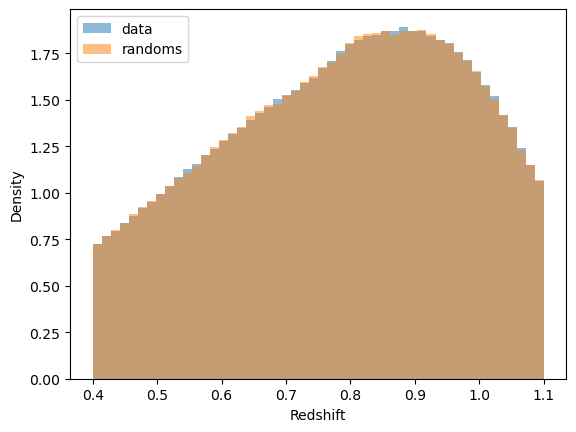

In [5]:
import matplotlib.pyplot as plt

plt.hist(data['Z'], weights=data['INDWEIGHT'], bins=50, alpha=0.5, label='data', density=True)
plt.hist(randoms['Z'], weights=randoms['INDWEIGHT'], bins=50, alpha=0.5, label='randoms', density=True)
plt.xlabel('Redshift')
plt.ylabel('Density')
plt.legend()
plt.show()